<a href="https://colab.research.google.com/github/virenemmanuel/BizCardX-Extracting-Business-Card-Data-with-OCR/blob/main/BizCardX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install easyocr

In [ ]:
! pip install streamlit

In [ ]:
! pip install streamlit_option_menu

In [4]:
import streamlit as st
from streamlit_option_menu import option_menu
import easyocr
from PIL import Image
import pandas as pd
import numpy as np
import re
import io
import sqlite3

2025-03-22 07:54:39.940 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [5]:
def image_to_text(path):

    input_image = Image.open(path)

    # Converting Image to array:
    image_array = np.array(input_image)

    reader = easyocr.Reader(['en'])
    text = reader.readtext(image_array, detail = 0)

    return text, input_image

In [ ]:
image_to_text("/content/1.png")

In [8]:
text_image, input_image = image_to_text("/content/2.png")

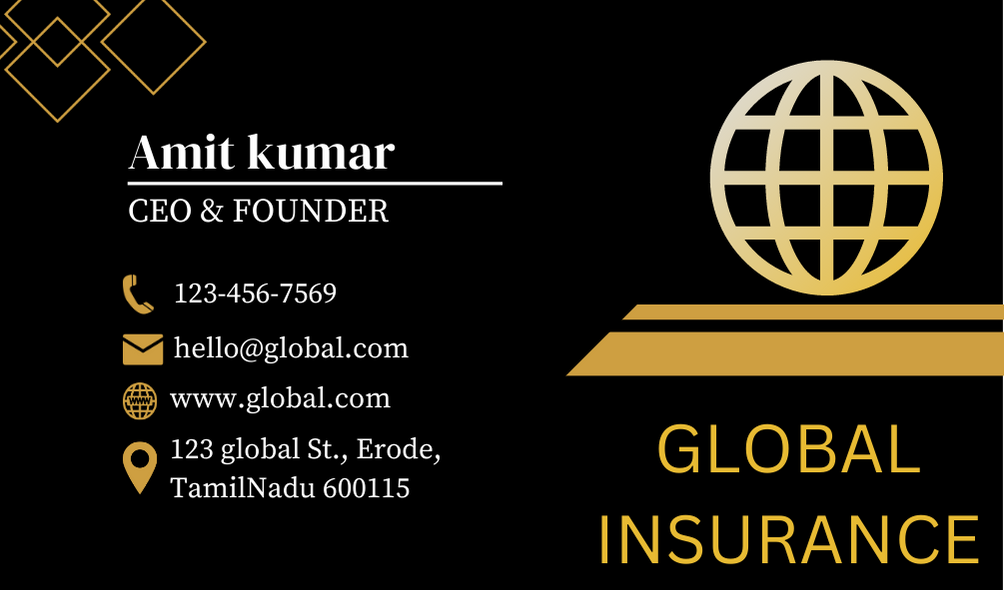

In [9]:
input_image

In [10]:
df = pd.DataFrame(text_image, columns=["Text"])
df

,Text
0,Amit kumar
1,CEO & FOUNDER
2,123-456-7569
3,hello@global.com
4,WWW
5,global.com
6,123 global
7,"Erode,"
8,GLOBAL
9,TamilNadu 600115


In [11]:
text_image

['Amit kumar',
 'CEO & FOUNDER',
 '123-456-7569',
 'hello@global.com',
 'WWW',
 'global.com',
 '123 global',
 'Erode,',
 'GLOBAL',
 'TamilNadu 600115',
 'INSURANCE',
 'St ,']

In [12]:
from typing import Concatenate
def extracted_text(texts):

  extracted_dict = {"NAME":[],"DESIGNATION":[],
                    "COMPANY_NAME":[],"CONTACT_NO":[],
                    "EMAIL_ADD":[],"WEBSITE":[],
                    "ADDRESS":[],"PIN_CODE":[]}

  extracted_dict["NAME"].append(texts[0])
  extracted_dict["DESIGNATION"].append(texts[1])

  for i in range(2,len(texts)):

    if texts[i].startswith("+") or (texts[i].replace("-","").isdigit() and '-' in texts[i]):

       extracted_dict["CONTACT_NO"].append(texts[i])

    elif "@" in texts[i] and ".com" in texts[i]:
      extracted_dict["EMAIL_ADD"].append(texts[i])

    elif "WWW" in texts[i] or "www" in texts[i] or "Www" in texts[i] or "wWw" in texts[i] or "wwW" in texts[i]:
      small = texts[i].lower()
      extracted_dict["WEBSITE"].append(small)

    elif "Tamil Nadu" in texts[i] or "TamilNadu" in texts[i] or texts[i].isdigit():
      extracted_dict["PIN_CODE"].append(texts[i])

    elif re.match(r'^[A-Za-z]',texts[i]):
      extracted_dict["COMPANY_NAME"].append(texts[i])

    else:
      remove_colone = re.sub('r[,;]','',texts[i])
      extracted_dict["ADDRESS"].append(remove_colone)

  for key,value in extracted_dict.items():
    if len(value) > 0:
      Concatenate = " ".join(value)
      extracted_dict[key] = Concatenate

    else:
      value = "NA"
      extracted_dict[key] = value

  return extracted_dict

In [13]:
text_data = extracted_text(text_image)

In [14]:
df = pd.DataFrame(text_data,  index=[0])
df

,NAME,DESIGNATION,COMPANY_NAME,CONTACT_NO,EMAIL_ADD,WEBSITE,ADDRESS,PIN_CODE
0,Amit kumar,CEO & FOUNDER,"global.com Erode, GLOBAL INSURANCE St ,",123-456-7569,hello@global.com,www,123 global,TamilNadu 600115


In [15]:
text_image

['Amit kumar',
 'CEO & FOUNDER',
 '123-456-7569',
 'hello@global.com',
 'WWW',
 'global.com',
 '123 global',
 'Erode,',
 'GLOBAL',
 'TamilNadu 600115',
 'INSURANCE',
 'St ,']

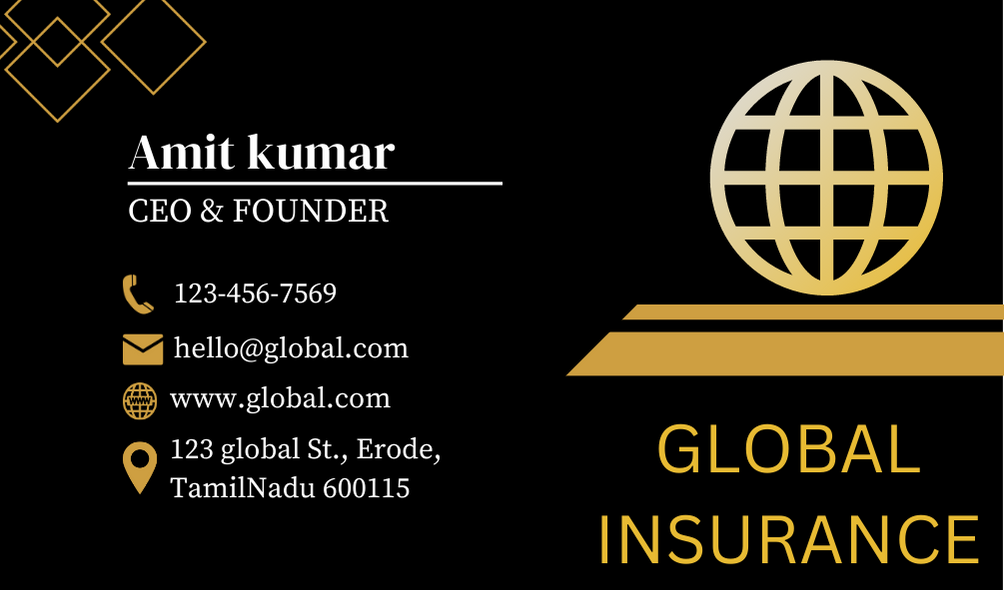

In [16]:
input_image

In [17]:
# Converting Image to Bytes
Image_bytes = io.BytesIO()
input_image.save(Image_bytes, format='PNG')
Image_Data = Image_bytes.getvalue()

# creating Dictionary
data = {"Image":[Image_Data]}

df_1 = pd.DataFrame(data)

concat_df = pd.concat([df,df_1], axis=1)
concat_df

,NAME,DESIGNATION,COMPANY_NAME,CONTACT_NO,EMAIL_ADD,WEBSITE,ADDRESS,PIN_CODE,Image
0,Amit kumar,CEO & FOUNDER,"global.com Erode, GLOBAL INSURANCE St ,",123-456-7569,hello@global.com,www,123 global,TamilNadu 600115,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [18]:
# Sql connection
mydb = sqlite3.connect("Bizcard.db")
cursor = mydb.cursor()

# creating sql Table
create_table_query = '''CREATE TABLE IF NOT EXISTS bizcard_table(name varchar(225),
                                                                 designation varchar(225),
                                                                 company_name varchar(225),
                                                                 contact_no varchar(225),
                                                                 email_id varchar(225),
                                                                 website text,
                                                                 address text,
                                                                 pin_code varchar(225),
                                                                 image text)'''

cursor.execute(create_table_query)
mydb.commit()

In [38]:
# insert query
insert_query = ''' INSERT INTO bizcard_table(name,
                                             designation,
                                             company_name,
                                             contact_no,
                                             email_id,
                                             website,
                                             address,
                                             pin_code,
                                             image)

                                             values(?,?,?,?,?,?,?,?,?)'''

datas = concat_df.values.tolist()[0]
cursor.execute(insert_query, datas)
mydb.commit()

In [41]:
# select query

select_query = '''SELECT NAME FROM bizcard_table'''
cursor.execute(select_query)
result = cursor.fetchall()
mydb.commit()

# table_df = pd.DataFrame(result, columns=("NAME","DESIGNATION","COMPANY_NAME","CONTACT_NO","EMAIL_ADD","WEBSITE","ADDRESS","PIN_CODE","Image"))
# table_df

names = []

for i in result:
  names.append(i[0])

names

['CEO & FOUNDER', 'DATA MANAGER', 'CEO & FOUNDER']

In [40]:
df_3 = table_df[table_df["NAME"] == "Amit kumar"]
df_3

,NAME,DESIGNATION,COMPANY_NAME,CONTACT_NO,EMAIL_ADD,WEBSITE,ADDRESS,PIN_CODE,Image


In [ ]:
datas = concat_df.values.tolist()
datas

In [ ]:
%%writefile Bizcard.py

import streamlit as st
from streamlit_option_menu import option_menu
import easyocr
from PIL import Image
import pandas as pd
import numpy as np
import re
import io
import sqlite3

def image_to_text(path):
    input_image = Image.open(path)

    # Converting Image to array:
    image_array = np.array(input_image)
    reader = easyocr.Reader(['en'])
    text = reader.readtext(image_array, detail = 0)

    return text, input_image

from typing import Concatenate
def extracted_text(texts):
  extracted_dict = {"NAME":[],"DESIGNATION":[],
                    "COMPANY_NAME":[],"CONTACT_NO":[],
                    "EMAIL_ADD":[],"WEBSITE":[],
                    "ADDRESS":[],"PIN_CODE":[]}

  extracted_dict["NAME"].append(texts[0])
  extracted_dict["DESIGNATION"].append(texts[1])

  for i in range(2,len(texts)):

    if texts[i].startswith("+") or (texts[i].replace("-","").isdigit() and '-' in texts[i]):

       extracted_dict["CONTACT_NO"].append(texts[i])

    elif "@" in texts[i] and ".com" in texts[i]:
      extracted_dict["EMAIL_ADD"].append(texts[i])

    elif "WWW" in texts[i] or "www" in texts[i] or "Www" in texts[i] or "wWw" in texts[i] or "wwW" in texts[i]:
      small = texts[i].lower()
      extracted_dict["WEBSITE"].append(small)

    elif "Tamil Nadu" in texts[i] or "TamilNadu" in texts[i] or texts[i].isdigit():
      extracted_dict["PIN_CODE"].append(texts[i])

    elif re.match(r'^[A-Za-z]',texts[i]):
      extracted_dict["COMPANY_NAME"].append(texts[i])

    else:
      remove_colone = re.sub('r[,;]','',texts[i])
      extracted_dict["ADDRESS"].append(remove_colone)

  for key,value in extracted_dict.items():
    if len(value) > 0:
      Concatenate = " ".join(value)
      extracted_dict[key] = Concatenate

    else:
      value = "NA"
      extracted_dict[key] = value

  return extracted_dict

# Streamlit section
st.set_page_config(layout="wide")
st.title("BIZCARDX: EXTRACTING BUSINESS CARD DATA WITH OCR")

with st.sidebar:
  select = option_menu("Main Menu",["Home","Upload & Modifying","Delete"])

if select == "Home":
  st.markdown("### :blue[**Technologies Used :**] Python,easy OCR, Streamlit, SQL, Pandas")

  st.write("### :green[**About :**] Bizcard is a Python application designed to extract information from business cards.")
  st.write("### The main purpose of Bizcard is to automate the process of extracting key details from business card images, such as the name, designation, company, contact information, and other relevant data. By leveraging the power of OCR (Optical Character Recognition) provided by EasyOCR, Bizcard is able to extract text from the images.")

elif select == "Upload & Modifying":
  img = st.file_uploader("Upload the Image", type= ["png","jpg","jpeg"])

  if img is not None:
    st.image(img,width= 300)

    text_image,input_img = image_to_text(img)

    text_dict = extracted_text(text_image)

    if text_dict:
      st.success("Text is Extracted Successfully")

    df = pd.DataFrame(text_dict, index=[0])

    # Converting Image to Bytes
    Image_bytes = io.BytesIO()
    input_img.save(Image_bytes, format='PNG')
    Image_Data = Image_bytes.getvalue()

    # creating Dictionary
    data = {"Image":[Image_Data]}

    df_1 = pd.DataFrame(data)

    concat_df = pd.concat([df,df_1], axis=1)
    st.dataframe(concat_df)

    button_1 = st.button("Save", use_container_width = True)

    if button_1:
      # Sql connection
      mydb = sqlite3.connect("Bizcard.db")
      cursor = mydb.cursor()

      # creating sql Table
      create_table_query = '''CREATE TABLE IF NOT EXISTS bizcard_table(name varchar(225),
                                                                      designation varchar(225),
                                                                      company_name varchar(225),
                                                                      contact_no varchar(225),
                                                                      email_id varchar(225),
                                                                      website text,
                                                                      address text,
                                                                      pin_code varchar(225),
                                                                      image text)'''
      cursor.execute(create_table_query)
      mydb.commit()

      # insert query
      insert_query = ''' INSERT INTO bizcard_table(name,
                                                   designation,
                                                   company_name,
                                                   contact_no,
                                                   email_id,
                                                   website,
                                                   address,
                                                   pin_code,
                                                   image)

                                                  values(?,?,?,?,?,?,?,?,?)'''
      datas = concat_df.values.tolist()
      cursor.execute(insert_query, datas[0])
      mydb.commit()

      st.success("SAVED SUCCESSFULLY")

  method = st.radio("Select the method",["None","Preview","Modify"])

  if method == "Preview":
    mydb = sqlite3.connect("Bizcard.db")
    cursor = mydb.cursor()

    # select query
    select_query = '''SELECT * FROM bizcard_table'''
    cursor.execute(select_query)
    result = cursor.fetchall()
    mydb.commit()

    table_df = pd.DataFrame(result, columns=("NAME","DESIGNATION","COMPANY_NAME","CONTACT_NO","EMAIL_ADD","WEBSITE","ADDRESS","PIN_CODE","IMAGE"))
    st.dataframe(table_df)

  elif method == "Modify":
    mydb = sqlite3.connect("Bizcard.db")
    cursor = mydb.cursor()

    #select query
    select_query = '''SELECT * FROM bizcard_table'''
    cursor.execute(select_query)
    result = cursor.fetchall()
    mydb.commit()

    table_df = pd.DataFrame(result, columns=("NAME","DESIGNATION","COMPANY_NAME","CONTACT_NO","EMAIL_ADD","WEBSITE","ADDRESS","PIN_CODE","IMAGE"))

    col1,col2 = st.columns(2)
    with col1:
      selected_name = st.selectbox("Select the Name",table_df["NAME"])

    df_3 = table_df[table_df["NAME"] == selected_name]

    st.dataframe(df_3)

    df_4 = df_3.copy()

    col1,col2 = st.columns(2)
    with col1:
      modify_name = st.text_input("Name",df_3["NAME"].unique()[0])
      modify_desig = st.text_input("Designation",df_3["DESIGNATION"].unique()[0])
      modify_company_nm = st.text_input("Company_name",df_3["COMPANY_NAME"].unique()[0])
      modify_Contact_no = st.text_input("Contact_no",df_3["CONTACT_NO"].unique()[0])
      modify_Email_add = st.text_input("Email_add",df_3["EMAIL_ADD"].unique()[0])

      df_4["NAME"] = modify_name
      df_4["DESIGNATION"] = modify_desig
      df_4["COMPANY_NAME"] = modify_company_nm
      df_4["CONTACT_NO"] = modify_Contact_no
      df_4["EMAIL_ADD"] = modify_Email_add

    with col2:
      modify_website = st.text_input("Website",df_3["WEBSITE"].unique()[0])
      modify_Address = st.text_input("Address",df_3["ADDRESS"].unique()[0])
      modify_Pin_code = st.text_input("Pin_code",df_3["PIN_CODE"].unique()[0])
      modify_Image = st.text_input("Image",df_3["IMAGE"].unique()[0])

      df_4["WEBSITE"] = modify_website
      df_4["ADDRESS"] = modify_Address
      df_4["PIN_CODE"] = modify_Pin_code
      df_4["IMAGE"] = modify_Image

    st.dataframe(df_4)

    col1,col2 = st.columns(2)
    with col1:
      button_3 = st.button("Modify", use_container_width=True)

    if button_3:
      mydb = sqlite3.connect("Bizcard.db")
      cursor = mydb.cursor()

      cursor.execute(f"DELETE FROM bizcard_table WHERE NAME = '{selected_name}'")
      mydb.commit()

      #insert query
      insert_query = ''' INSERT INTO bizcard_table(name,
                                                    designation,
                                                    company_name,
                                                    contact_no,
                                                    email_id,
                                                    website,
                                                    address,
                                                    pin_code,
                                                    image)

                                                  values(?,?,?,?,?,?,?,?,?)'''
      datas = df_4.values.tolist()
      cursor.execute(insert_query, datas[0])
      mydb.commit()

      st.success("MODIFIED SUCCESSFULLY")

elif select == "Delete":
  mydb = sqlite3.connect("Bizcard.db")
  cursor = mydb.cursor()

  col1,col2 = st.columns(2)
  with col1:
    # select query
    select_query = '''SELECT NAME FROM bizcard_table'''
    cursor.execute(select_query)
    result = cursor.fetchall()
    mydb.commit()

    names = []
    for i in result:
      names.append(i[0])

    name_select = st.selectbox("Select the Name", names)

  with col2:
  # select query
    select_query = f'''SELECT DESIGNATION FROM bizcard_table WHERE NAME = '{name_select}' '''
    cursor.execute(select_query)
    result1 = cursor.fetchall()
    mydb.commit()

    # table_df = pd.DataFrame(result, columns=("NAME","DESIGNATION","COMPANY_NAME","CONTACT_NO","EMAIL_ADD","WEBSITE","ADDRESS","PIN_CODE","Image"))
    # table_df
    designations = []

    for j in result1:
      designations.append(j[0])

    designation_select = st.selectbox("Select the designation", designations)

  if name_select and designation_select:
    col1,col2,col3 = st.columns(3)

    with col1:
      st.write(f"Selected Name : {name_select}")
      st.write("")
      st.write("")
      st.write(f"Selected Designation : {designation_select}")

    with col2:
      st.write("")
      st.write("")
      st.write("")
      st.write("")

      remove = st.button("Delete",use_container_width=True)
      if remove:

        cursor.execute(f"DELETE FROM bizcard_table WHERE NAME = '{name_select}' AND DESIGNATION = '{designation_select}'")
        mydb.commit()

        st.warning("DELETED")

In [22]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [23]:
!wget -q -O - http://ipv4.icanhazip.com

34.48.149.143


In [ ]:
! streamlit run Bizcard.py & npx localtunnel --port 8501